In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
#from  sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import sklearn.model_selection as ms
import seaborn as sns
import matplotlib
from sklearn.preprocessing import Binarizer
import sklearn
import math
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from scipy.stats import norm, skew #for some statistics


In [2]:
df1=pd.read_csv(r"C:\Users\SaurabhM\Desktop\data\train_NIR5Yl1.csv")
df2=pd.read_csv(r"C:\Users\SaurabhM\Desktop\data\test_8i3B3FC.csv")

In [3]:
"""
dummies = pd.get_dummies(df[col],prefix=col)
df = pd.concat([df,dummies],axis=1)

#drop the encoded column
df.drop([col],axis = 1 , inplace=True)



Full function for this work:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    
    
"""
labelencoder_X = LabelEncoder()

df1['Tag'] = labelencoder_X.fit_transform(df1['Tag'])

"""
bn = Binarizer(threshold=7)
pd_watched = bn.transform([df1['Answers']])[0]
df1['pd_watched'] = pd_watched
"""



target=df1["Upvotes"]

df1 = df1.drop(["ID","Username"],axis = 1)

In [4]:
df1.head()

,Tag,Reputation,Answers,Views,Upvotes
0,0,3942.0,2.0,7855.0,42.0
1,0,26046.0,12.0,55801.0,1175.0
2,1,1358.0,4.0,8067.0,60.0
3,0,264.0,3.0,27064.0,9.0
4,1,4271.0,4.0,13986.0,83.0


In [5]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = df1.dtypes[df1.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df1[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Upvotes,74.249352
Views,14.370639
Reputation,11.229976
Answers,3.380153
Tag,0.337229



 mu = 337.51 and sigma = 3592.44



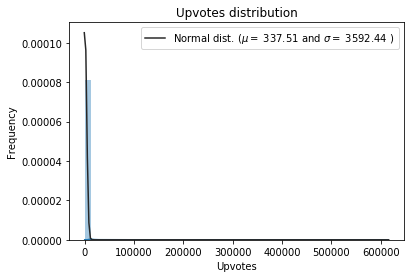

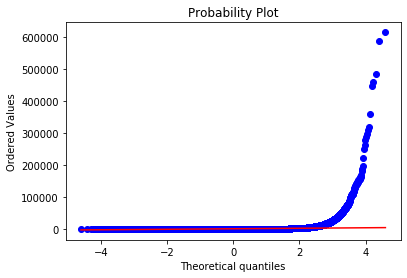

In [6]:

sns.distplot(df1['Upvotes'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1['Upvotes'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Upvotes distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df1['Upvotes'], plot=plt)
plt.show()


 mu = 3.54 and sigma = 1.84



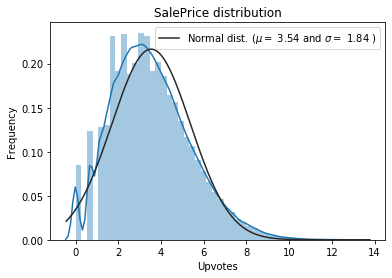

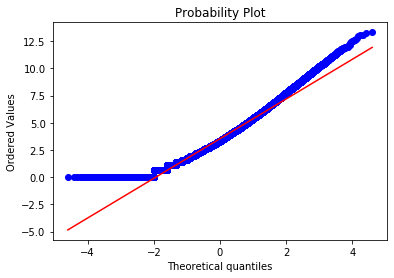

In [7]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df1["Upvotes"] = np.log1p(df1["Upvotes"])

#Check the new distribution 
sns.distplot(df1["Upvotes"] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df1["Upvotes"])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df1["Upvotes"], plot=plt)
plt.show()

In [11]:
#Skewness Feature

numeric_feats = df1.dtypes[df1.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = df1[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
Views,14.370639
Reputation,11.229976
Answers,3.380153
Upvotes,0.554038
Tag,0.337229


In [12]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    df1[feat] = boxcox1p(df1[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 5 skewed numerical features to Box Cox transform


In [13]:
skewness

,Skew
Views,14.370639
Reputation,11.229976
Answers,3.380153
Upvotes,NaN
Tag,NaN


In [14]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [36]:
train = df1[:200000]
test = df1[200000:]
y_train=train["Upvotes"]
train=train.drop(["Upvotes"],axis=1)
y_test=test["Upvotes"]
test=test.drop(["Upvotes"],axis=1)

In [38]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)



In [39]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [40]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [41]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [42]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [43]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [44]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [45]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2902 (0.0023)



In [46]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.2902 (0.0023)



In [49]:
"""

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
"""

'\n\nscore = rmsle_cv(GBoost)\nprint("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))\n'

In [51]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.2902 (0.0023)



In [52]:

#Average base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 



In [53]:

averaged_models = AveragingModels(models = (ENet, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


 Averaged base models score: 0.2902 (0.0023)



In [54]:

#Stacking Average models class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)



In [55]:

stacked_averaged_models = StackingAveragedModels(base_models = (ENet, lasso),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))


C:\Users\SaurabhM\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
C:\Users\SaurabhM\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

  FitFailedWarning)
C:\Users\SaurabhM\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#d

Stacking Averaged models score: nan (nan)
